In [3]:
import gseapy as gp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

keys = [
    'tregs.tissue.scps.sat1',
    'tregs.tissue.scps.sat1hi',
    'tregs.tissue.scps.sat1lo'
]
dea_results = {
    k: pd.read_csv(
        f'../diffexp/{k}.de.all.tsv',
        sep = '\t'
    )
    for k
    in keys
}

In [4]:
def enrich_dea_results(
    dea_results,
    lfc_threshold,
    alpha,
    gene_sets,
    organism = 'Human',
    **kwargs
):
    gsea_results = []
    for regulation in ['upregulated', 'downregulated']: 
        if regulation == 'upregulated':
            is_significant = (
                (dea_results.p_val_adj < alpha) & 
                (dea_results.avg_log2FC > lfc_threshold)
            )

        else:
            is_significant = (
                (dea_results.p_val_adj < alpha) & 
                (dea_results.avg_log2FC < -lfc_threshold)
            )

        gsea_result = gp.enrichr(
            gene_list = dea_results[is_significant].gene.to_list(),
            gene_sets = gene_sets,
            organism = organism,
            outdir = None,
            **kwargs
        ).results
        gsea_result['regulation'] = regulation
        gsea_results.append(gsea_result)

    return pd.concat(gsea_results)

enrichment_results = {
    k: enrich_dea_results(
        dea_result,
        lfc_threshold = 0.25,
        alpha = 0.001,
        gene_sets = ['MSigDB_Hallmark_2020']
    )
    for k, dea_result
    in dea_results.items()
}

In [10]:
enrichment_results['tregs.tissue.scps.sat1']

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,regulation
0,MSigDB_Hallmark_2020,TNF-alpha Signaling via NF-kB,50/200,1.189043e-42,5.469598e-41,0,0,20.752929,2003.392790,BTG3;CDKN1A;BTG1;CD83;TNFAIP3;SLC2A3;SAT1;ZFP3...,upregulated
1,MSigDB_Hallmark_2020,Hypoxia,30/200,4.450951e-19,1.023719e-17,0,0,10.316375,435.928739,PPP1R15A;CDKN1A;BTG1;CXCR4;TNFAIP3;RORA;SLC2A3...,upregulated
2,MSigDB_Hallmark_2020,IL-2/STAT5 Signaling,29/199,3.973229e-18,6.092284e-17,0,0,9.942638,398.371216,PHTF2;CD83;RORA;SLC2A3;CST7;SYNGR2;CCND2;NFKBI...,upregulated
3,MSigDB_Hallmark_2020,mTORC1 Signaling,28/200,4.500300e-17,5.175346e-16,0,0,9.458868,356.029939,PPP1R15A;IDI1;CDKN1A;TFRC;INSIG1;UBE2D3;CXCR4;...,upregulated
4,MSigDB_Hallmark_2020,Apoptosis,24/161,1.950157e-15,1.794145e-14,0,0,10.076868,341.312263,BNIP3L;BTG3;JUN;CDKN1A;GADD45B;GADD45A;HMGB2;H...,upregulated
...,...,...,...,...,...,...,...,...,...,...,...
24,MSigDB_Hallmark_2020,G2-M Checkpoint,1/200,6.457826e-01,6.457826e-01,0,0,0.970440,0.424366,STMN1,downregulated
25,MSigDB_Hallmark_2020,Complement,1/200,6.457826e-01,6.457826e-01,0,0,0.970440,0.424366,LCK,downregulated
26,MSigDB_Hallmark_2020,Myc Targets V1,1/200,6.457826e-01,6.457826e-01,0,0,0.970440,0.424366,PABPC1,downregulated
27,MSigDB_Hallmark_2020,Epithelial Mesenchymal Transition,1/200,6.457826e-01,6.457826e-01,0,0,0.970440,0.424366,IL32,downregulated


tregs.tissue.scps.sat1
tregs.tissue.scps.sat1hi
tregs.tissue.scps.sat1lo


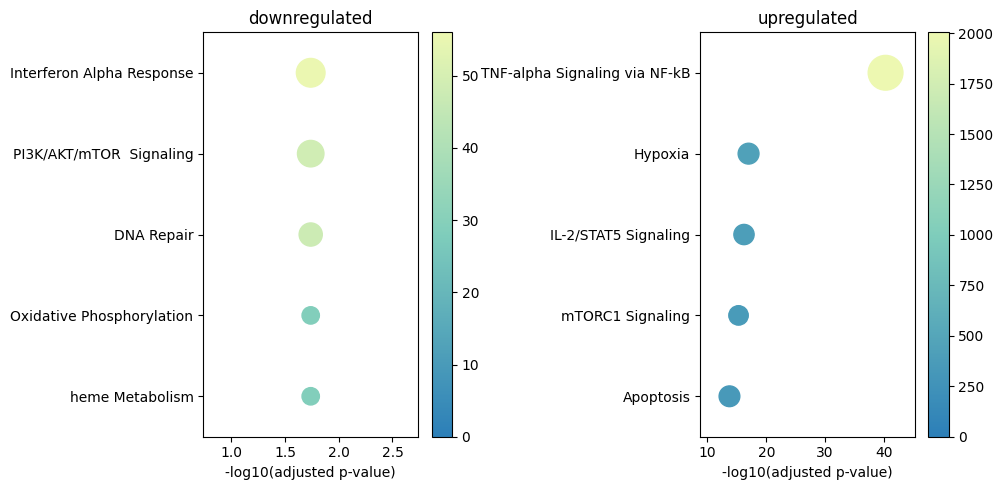

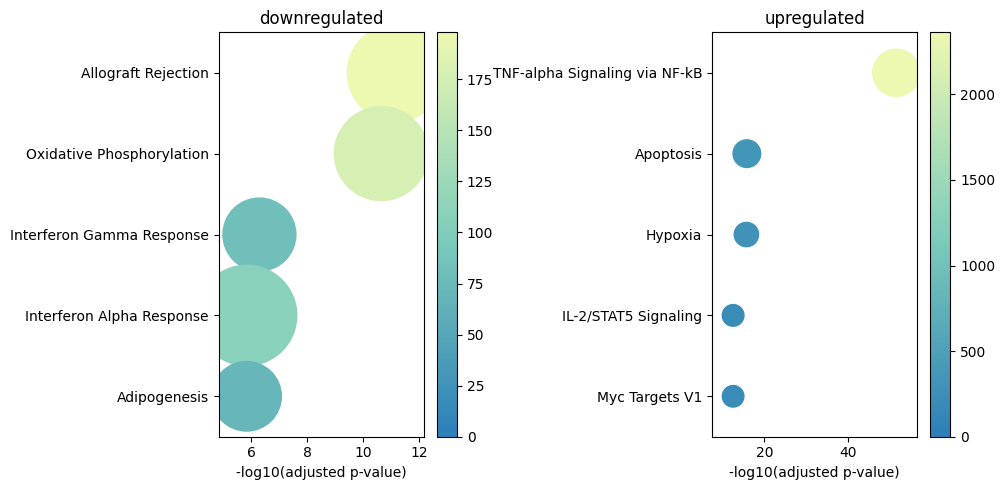

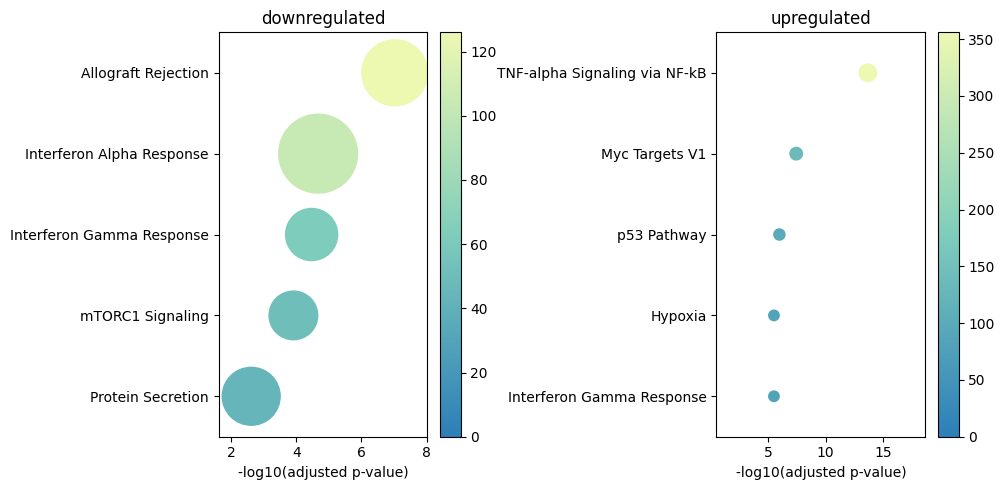

In [8]:
%matplotlib inline
import matplotlib as mpl

from matplotlib.colors import LinearSegmentedColormap, Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable


mpl.rcParams['pdf.fonttype'] = 42


def compute_percent_overlap(x):
    n_genes_in_overlap, n_genes_in_set = [int(i) for i in x.split('/')]
    return n_genes_in_overlap/n_genes_in_set * 100


def compute_dotsize():
    pass


# there is a legend for the dotsize missing
def enrichment_dotplot(enrichment_results):
    fig, axs = plt.subplots(1, 2)
    for ax, size, x_add, (key, df) in zip(axs, [5, 1], [1, 5], enrichment_results.items()):
        df = df.sort_values(by = 'Adjusted P-value').head(n = 5)
        df['percent_overlap'] = df.Overlap.apply(
            compute_percent_overlap
        )
        df['-log10_padj'] = -np.log10(df['Adjusted P-value'])
        df.sort_values(
            by = ['-log10_padj', 'percent_overlap'], 
            ascending = False,
            inplace = True
        )
        log_combined_scores = df['Combined Score']
        cbar_max = np.ceil(log_combined_scores.max())
        norm = Normalize(0, cbar_max)
        y = range(len(df), 0, -1)
        x = -np.log10(df['Adjusted P-value'])
        ax.scatter(
            x = x,
            y = y,
            s = (df.percent_overlap * size) ** 2,
            c = cmap(norm(log_combined_scores))
        )
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        fig.colorbar(sm, ax = ax)
        ax.set_ylim(min(y) - 0.5, max(y) + 0.5)
        ax.set_xlim(min(x) - x_add, max(x) + x_add)
        ax.set_yticks(y)
        ax.set_yticklabels(df.Term)
        ax.set_xlabel('-log10(adjusted p-value)')
        ax.set_title(key)
        
    return fig


cmap = LinearSegmentedColormap.from_list(
    'petrols',
    ['#edf8b1', '#7fcdbb', '#2c7fb8'][::-1],
    255
)


for k, df in enrichment_results.items():
    print(k)
    regulated = {
        k: group for k, group in df.groupby('regulation')
    }
    fig = enrichment_dotplot(regulated)
    
    fig.set_figwidth(10)
    fig.set_figheight(5)
    fig.tight_layout()
    fig.savefig(f'../plots/{k}.gsea.pdf')